# Imports

In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   History, Model,
                   ModelResult, MedianEpsilon)
from pyabc.transition import MultivariateNormalTransition
from pyabc.visualization import plot_kde_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'
import os
import tempfile
import math
import pandas as pd
import scipy as sp
import numpy as np
import subprocess
from io import BytesIO

from pyabc_custom import MyokitSimulation
from prangle_distance import PrangleDistance, PrangleEpsilon, PranglePopulationSize

ModuleNotFoundError: No module named 'pyabc_custom'

# Get experimental measurements

In [ ]:
myokit_python = ("/s/chouston/miniconda3/envs" +
                 "/ion_channel_ABC/bin/python")
args = [myokit_python, "get_measurements.py"]
args.append('icat')
re = subprocess.run(args, stdout=subprocess.PIPE)
measurements = pd.read_table(BytesIO(re.stdout),
                             delim_whitespace=True,
                             header=0, index_col=False)
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']

# Set limits and generate uniform initial priors

In [3]:
limits = dict(g_CaT=(0, 2),
              E_CaT=(0, 50),
              p1=(0, 100),
              p2=(0, 10),
              p3=(0, 2), # increased from (0, 1) to (0, 2) after initial run
              p4=(0, 10),
              p5=(0, 0.1),
              p6=(0, 200),
              q1=(0, 100),
              q2=(0, 10),
              q3=(0, 10),
              q4=(0, 100),
              q5=(0, 0.1),
              q6=(0, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Define ABC parameters and initialize database

In [4]:
myokit_model = MyokitSimulation('icat')

In [ ]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl-1_icat.db"))

In [ ]:
abc = ABCSMC(models=myokit_model,
             parameter_priors=prior,
             distance_function=PrangleDistance(exp_map=exp,
                                               alpha=0.5,
                                               delta=0.5,
                                               adapt=False),
             population_size=PranglePopulationSize(5000, 0.5,
                 adapt=True,
                 mean_cv=0.5, 
                 min_population_size=200,
                 max_population_size=5000),
             eps=PrangleEpsilon())

In [ ]:
abc_id = abc.new(db_path, obs)

In [ ]:
history = abc.run(minimum_epsilon=0.29, max_nr_populations=50)

In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

In [ ]:
df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits, colorbar=False)

In [ ]:
from visualization_custom import plot_sim_results
import matplotlib.style as style
import seaborn as sns
sns.set(style=""
plot_sim_results(history, "icat", n_samples=10, obs=measurements)

In [ ]:
from visualization_custom import plot_kde_2d_custom
g = plot_kde_2d_custom(history, "g_CaT", "E_CaT", times=[0, 1, 5, 10, 50], limits=limits)
plt.savefig('icat_convergence.pdf', format='pdf', dpi=1000) # save to disk

In [ ]:
history = abc.run(minimum_epsilon=0, max_nr_populations=30)

In [5]:
history = History("sqlite:///pyabc-runs/hl-1_icat.db")

In [6]:
history.all_runs()

[<ABCSMC(id=1, start_time=2018-05-25 15:22:27.077816, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-05-25 17:18:58.109548, end_time=None)>,
 <ABCSMC(id=3, start_time=2018-05-27 13:37:42.269082, end_time=2018-05-27 15:38:21.650434)>,
 <ABCSMC(id=4, start_time=2018-05-27 16:20:28.878427, end_time=2018-06-02 13:06:08.020335)>]

In [7]:
history.id = 4

/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


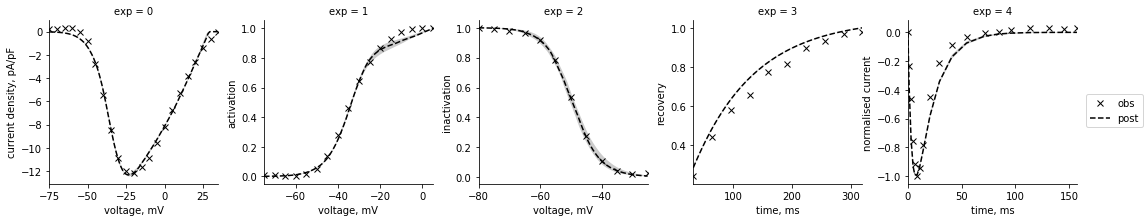

In [12]:
from visualization_custom import plot_sim_results
g = plot_sim_results(history, 'icat', n_samples=10, obs=measurements, original=False)
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms"]
ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
plt.savefig('icat_results.pdf', format='pdf', dpi=1000)

In [ ]:
df, w = abc.history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits, colorbar=False)

In [9]:
df, w = history.get_distribution(m=0)
df['wt'] = w
print("Mean")
for key in limits.keys():
    print(key, ":", sum(df[key] * df.wt))
print("Min")
for key in limits.keys():
    print(key, ":", min(df[key]))
print("Max")
for key in limits.keys():
    print(key, ":", max(df[key]))

Mean
g_CaT : 0.5744908621955785
E_CaT : 28.688434556455498
p1 : 33.02010315542557
p2 : 5.235044985417687
p3 : 1.739221978342799
p4 : 8.504914305936953
p5 : 0.07814348621785701
p6 : 24.05813303087214
q1 : 49.60948195877267
q2 : 4.478886531183562
q3 : 8.912086091428748
q4 : 98.5809348344708
q5 : 0.0929796738597656
q6 : 47.774480925643395
Min
g_CaT : 0.44240216918930636
E_CaT : 26.601785250960805
p1 : 30.103652652864373
p2 : 4.4227533244180055
p3 : 0.3121506832271061
p4 : 3.7475450416523706
p5 : 0.01019702339436698
p6 : 0.08305676051712929
q1 : 47.340789491988495
q2 : 2.9133251365855894
q3 : 5.419653056761908
q4 : 92.68667563732247
q5 : 0.07369100955334765
q6 : 41.01004391360781
Max
g_CaT : 0.9143096058728483
E_CaT : 31.820622967475625
p1 : 35.25846761133867
p2 : 6.017069200381783
p3 : 1.9998523874892515
p4 : 9.999608428079764
p5 : 0.09999949850367026
p6 : 38.853879597204006
q1 : 51.63890095944256
q2 : 6.0406551854576644
q3 : 9.99928485206019
q4 : 99.99991668823989
q5 : 0.0999972884734687

Initial run with reduced population to identify unconstrainable parameters.

In [ ]:
abc = ABCSMC(models=MyokitSimulation(),
             parameter_priors=prior,
             distance_function=distance,
             population_size=500,
             eps=MedianEpsilon(100, median_multiplier=1.0))
abc_id = abc.new(db_path, obs)

In [ ]:
history_init = abc.run(max_nr_populations=10, minimum_epsilon=0.01)

In [ ]:
from visualization_custom import plot_sim_results
plot_sim_results(history_init, "icat", n_samples=100, obs=measurements)

In [ ]:
df, w = history_init.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

In [ ]:
history_init = abc.run(max_nr_populations=20, minimum_epsilon=0.01)

In [ ]:
from visualization_custom import plot_sim_results
plot_sim_results(history_init, "icat", n_samples=100, obs=measurements)

In [ ]:
df, w = history_init.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

Reduce parameters varied and run with adaptive population size.

In [ ]:
abc = ABCSMC(models=MyokitSimulation(),
             parameter_priors=prior,
             distance_function=distance,
             population_size=AdaptivePopulationSize(
                 5000, 0.5, 
                 min_population_size=500,
                 max_population_size=10000),
            eps=MedianEpsilon(100, median_multiplier=1.0))
abc_id = abc.new(db_path, obs)

In [ ]:
history = abc.run(max_nr_populations=20, minimum_epsilon=0.5)